In [1]:
include("plotregion.jl")
using Plots

ezcontour!(x, y, f) = begin
    X = repeat(x', length(y), 1)
    Y = repeat(y, 1, length(x))
    # Evaluate each f(x, y) =
    Z = map((x,y) -> (f([x,y])), X, Y)
    plot!(x, y, Z, st=:contour)
end

ezcontour! (generic function with 1 method)

In [4]:
# 
#  min  1/2 x'*G*x + c'*x
#  s.t. Ax = b
#       Bx >= d
using Printf
mutable struct QPProblem
    G::Matrix{Float64}
    c::Vector{Float64}
    
    A::Matrix{Float64}
    b::Vector{Float64}
    
    B::Matrix{Float64}
    d::Vector{Float64}
end

mutable struct QPActiveState
    x::Vector{Float64}
    W::Set{Int}
    flag::Bool
    fval::Float64
    P::QPProblem
end

"""A very simple QP KKT solver"""
function qp_kkt_solve(P::QPProblem, W::Set{Int}, x::Vector{Float64})
    Aeq = [P.A; P.B[collect(W),:]];
    n = size(P.G,1)
    m1 = size(P.A,1)
    m2 = size(Aeq,1)
    g = P.G*x + P.c
    G = P.G
    
    sys = [G Aeq'; Aeq zeros(m2,m2)]
    rhs = [g; zeros(m2,1)]
    sol = sys\rhs
    p = -sol[1:n]
    lam = sol[n+1:n+m1]
    mu = zeros(size(P.B,1))
    mu[collect(W)] = sol[n+m1+1:n+m2]
    return p, lam, mu
end

function fval(P::QPProblem, x::Vector{Float64})
    if length(P.b) > 0 && norm(P.A*x - P.b) >= 1.0e-8*length(P.b)
        return Inf
    elseif any(P.B*x - P.d .<= -1.0e-8)
        return Inf
    else
        return 0.5*dot(P.G*x, x) + dot(P.c, x)
    end     
end

# Setup an active set method for
#  min  1/2 x'*G*x + c'*x
#  s.t. Ax = b
#       Bx >= d
# with W as the initial working set
function qp_init(G,c,A,b,B,d,W, x0)
    P = QPProblem(G,c,A,b,B,d)
    
    W = Set{Int}(W) # make a copy
    #p, lam, mu = kkt_solve(P, W, x0)
    
    return QPActiveState(x0, W, false, fval(P,x0), P)
end

# Take a step for an active set method for
#  min  1/2 x'*G*x + c'*x
#  s.t. Ax = b
#       Bx >= d
function qp_activeset_step!(S::QPActiveState)
    p, lam, mu = qp_kkt_solve(S.P, S.W, S.x)
    note = "stepped" #default case
    if norm(p) <= 100*eps(1.0)
        # we are done, or update working set
        xn = S.x
        if all(mu .>= -100*eps(1.0))
            S.flag = true # solved it!
        else
            j = findmin(mu)[2]
            delete!(S.W,j)
            note = "removed $j"
        end
    else
        # we need to move
        # find the first constraint we hit that isn't
        # in the working set
        alpha = 1.0
        ind = 0
        
        for i = 1:size(S.P.B,1)
            # for each inequal constraint
            if i in S.W
                # do nothing
            else
                bi = S.P.B[i,:]
                di = S.P.d[i]
                if dot(bi,p) < -100*eps(1.0) # then we might hit a constraint
                    testalpha = (di - dot(bi,S.x))/(dot(bi,p))
                    if testalpha < alpha
                        alpha = testalpha
                        ind = i
                    end
                end
            end
        end
        
        xn = S.x + alpha*p
        if ind > 0
            push!(S.W,ind) # add ind to the working set
            note = "added $ind"
        end
    end
    S.x = xn
    S.fval = fval(S.P, S.x)
    if length(mu) > 3 
        @printf("Step: f=%4.1f  x=[%4.1f,%4.1f]  mu=[%-4.1f,%-4.1f,%-4.1f,%-4.1f]   note=%s\n",
                        S.fval, S.x[1], S.x[2], mu[1], mu[2], mu[3], mu[4], note)
    elseif length(mu) == 3
        @printf("Step: f=%4.1f  x=[%4.1f,%4.1f]  mu=[%-4.1f,%-4.1f,%-4.1f]   note=%s\n",
                        S.fval, S.x[1], S.x[2], mu[1], mu[2], mu[3], note)
    elseif length(mu) == 2
        @printf("Step: f=%4.1f  x=[%4.1f,%4.1f]  mu=[%-4.1f,%-4.1f]   note=%s\n",
                        S.fval, S.x[1], S.x[2], mu[1], mu[2], note)
    elseif length(mu) == 1
        @printf("Step: f=%4.1f  x=[%4.1f,%4.1f]  mu=[%-4.1f]   note=%s\n",
                        S.fval, S.x[1], S.x[2], mu[1], note)
    elseif length(mu) == 0
        @printf("Step: f=%4.1f  x=[%4.1f,%4.1f]  mu=[]   note=%s\n",
                        S.fval, S.x[1], S.x[2],  note)
    end

    return S                
end

qp_activeset_step! (generic function with 1 method)

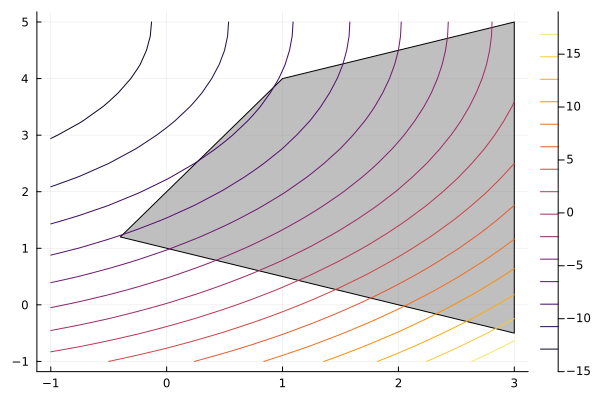

In [2]:
using LinearAlgebra
n = 2
G = Matrix(1.0I, n, n)
c = zeros(n)
c[1] = 3; c[2] = -5
#f = @(x) 0.5*(x'*G*x) + c'*x
A = [-2 1; -1 2; 1 0; -0.5 -1]
b = [2; 7; 3; -1.0]

# We used Matlab to determine the vertices of the feasible polytope
plot(Shape([-0.4,3,3,1],[1.2,-0.5,5,4]),fillalpha=0.5, fillcolor="grey", label="")
ezcontour!(-1.0:0.25:3.0,-1.0:0.25:5.0,x -> 0.5*dot(G*x,x) + dot(c,x))

In [5]:
x0 = [3.0;0.0]
W = [3]
S = qp_init(G,c,zeros(0,n),zeros(0),-A,-b,W,x0)
qp_activeset_step!(S)
qp_activeset_step!(S)
qp_activeset_step!(S)



Step: f= 1.0  x=[ 3.0, 5.0]  mu=[0.0 ,0.0 ,-6.0,0.0 ]   note=stepped
Step: f= 1.0  x=[ 3.0, 5.0]  mu=[0.0 ,0.0 ,-6.0,0.0 ]   note=removed 3
Step: f= 1.0  x=[ 3.0, 5.0]  mu=[0.0 ,0.0 ,0.0 ,0.0 ]   note=added 2


QPActiveState([3.0, 5.0], Set([2]), false, 1.0, QPProblem([1.0 0.0; 0.0 1.0], [3.0, -5.0], Matrix{Float64}(undef, 0, 2), Float64[], [2.0 -1.0; 1.0 -2.0; -1.0 -0.0; 0.5 1.0], [-2.0, -7.0, -3.0, 1.0]))

In [6]:
qp_activeset_step!(S)

Step: f=-8.5  x=[ 1.0, 4.0]  mu=[0.0 ,1.2 ,0.0 ,0.0 ]   note=added 1


QPActiveState([1.0, 4.0], Set([2, 1]), false, -8.5, QPProblem([1.0 0.0; 0.0 1.0], [3.0, -5.0], Matrix{Float64}(undef, 0, 2), Float64[], [2.0 -1.0; 1.0 -2.0; -1.0 -0.0; 0.5 1.0], [-2.0, -7.0, -3.0, 1.0]))

Step: f= 1.0  x=[ 3.0, 5.0]  mu=[0.0 ,0.0 ,-6.0,0.0 ]   note=stepped
Step: f= 1.0  x=[ 3.0, 5.0]  mu=[0.0 ,0.0 ,-6.0,0.0 ]   note=removed 3
Step: f= 1.0  x=[ 3.0, 5.0]  mu=[0.0 ,0.0 ,0.0 ,0.0 ]   note=added 2
Step: f=-8.5  x=[ 1.0, 4.0]  mu=[0.0 ,1.2 ,0.0 ,0.0 ]   note=added 1
Step: f=-8.5  x=[ 1.0, 4.0]  mu=[2.3 ,-0.7,0.0 ,0.0 ]   note=removed 2
Step: f=-8.9  x=[ 0.6, 3.2]  mu=[1.8 ,0.0 ,0.0 ,0.0 ]   note=stepped
Step: f=-8.9  x=[ 0.6, 3.2]  mu=[1.8 ,0.0 ,0.0 ,0.0 ]   note=stepped


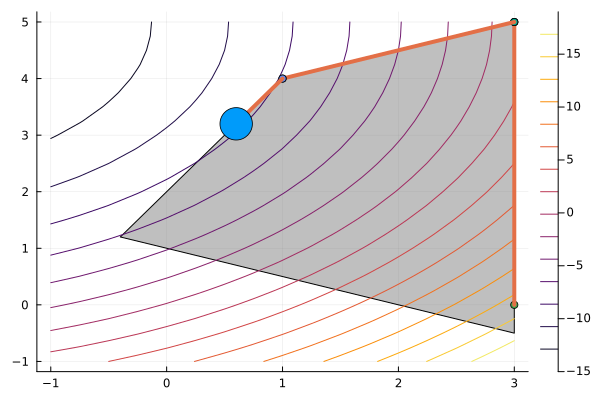

In [7]:
# Animate!
plot(Shape([-0.4,3,3,1],[1.2,-0.5,5,4]),fillalpha=0.5, fillcolor="grey", label="")
ezcontour!(-1.0:0.25:3.0,-1.0:0.25:5.0,x -> 0.5*dot(G*x,x) + dot(c,x))

x0 = [3.0;0.0]
W = [3]
S = qp_init(G,c,zeros(0,n),zeros(0),-A,-b,W,x0)
for i=1:10
    xold = S.x
    scatter!([S.x[1]], [S.x[2]], label="")
    qp_activeset_step!(S)
    xnew = S.x
    #plot!([xold[1],xnew[1]], [xold[2],xnew[2]], marker=:none, label="")
    plot!([xold[1],xnew[1]], [xold[2],xnew[2]], label="", color=2, linewidth=4)
    if S.flag == true
        break
    end
end

if S.flag == true
    scatter!([S.x[1]], [S.x[2]], label="", markersize=18)
end
plot!()





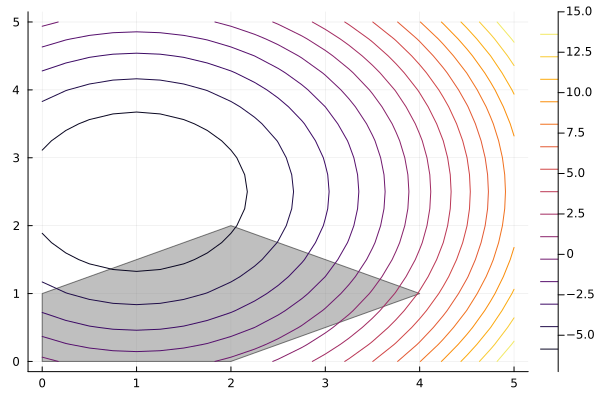

In [8]:
# Show a problem from Figure 16.3 in Nocedal and Wright

n = 2
G = 2*Matrix(1.0I,n,n)
c = [-2.0; -5]
A = [1.0 -2; -1 -2; -1 2; 1 0; 0 1]
b = [-2.0; -6; -2; 0; 0]
# this is Ax >= b

# plotregion uses Ax = b, x >=0 
PlotRegion.plotregion([A -Matrix(1.0I, size(A,1), size(A,1))],b)
ezcontour!(0:0.25:5.0,0:0.25:5.0,x -> 0.5*dot(G*x,x) + dot(c,x))

Step: f= 0.0  x=[ 2.0, 0.0]  mu=[0.0 ,0.0 ,-2.0,0.0 ]   note=removed 3
Step: f=-1.0  x=[ 1.0, 0.0]  mu=[0.0 ,0.0 ,0.0 ,0.0 ]   note=stepped
Step: f=-1.0  x=[ 1.0, 0.0]  mu=[0.0 ,0.0 ,0.0 ,0.0 ]   note=removed 5
Step: f=-6.2  x=[ 1.0, 1.5]  mu=[0.0 ,0.0 ,0.0 ,0.0 ]   note=added 1
Step: f=-6.4  x=[ 1.4, 1.7]  mu=[0.8 ,0.0 ,0.0 ,0.0 ]   note=stepped
Step: f=-6.4  x=[ 1.4, 1.7]  mu=[0.8 ,0.0 ,0.0 ,0.0 ]   note=stepped


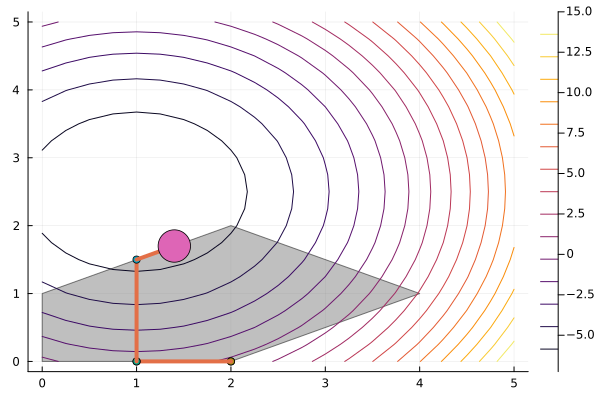

In [9]:
# Animate!
PlotRegion.plotregion([A -Matrix(1.0I,size(A,1),size(A,1))],b)
ezcontour!(0:0.25:5.0,0:0.25:5.0,x -> 0.5*dot(G*x,x) + dot(c,x))

x0 = [2.0;0.0]
W = [3,5]
S = qp_init(G,c,zeros(0,n),zeros(0),A,b,W,x0)
for i=1:10
    xold = S.x
    scatter!([S.x[1]], [S.x[2]], label="")
    qp_activeset_step!(S)
    xnew = S.x
    plot!([xold[1],xnew[1]], [xold[2],xnew[2]], label="", color=2, linewidth=4)
    if S.flag == true
        break
    end
end

if S.flag == true
    scatter!([S.x[1]], [S.x[2]], label="", markersize=18)
end
plot!()






Step: f=-2.0  x=[ 2.0, 0.0]  mu=[0.0 ,0.0 ,-1.0,0.0 ]   note=removed 3
Step: f=-2.2  x=[ 1.5, 0.0]  mu=[0.0 ,0.0 ,0.0 ,0.0 ]   note=stepped
Step: f=-2.2  x=[ 1.5, 0.0]  mu=[0.0 ,0.0 ,0.0 ,0.0 ]   note=removed 5
Step: f=-2.5  x=[ 1.5, 0.5]  mu=[0.0 ,0.0 ,0.0 ,0.0 ]   note=stepped
Step: f=-2.5  x=[ 1.5, 0.5]  mu=[0.0 ,0.0 ,0.0 ,0.0 ]   note=stepped


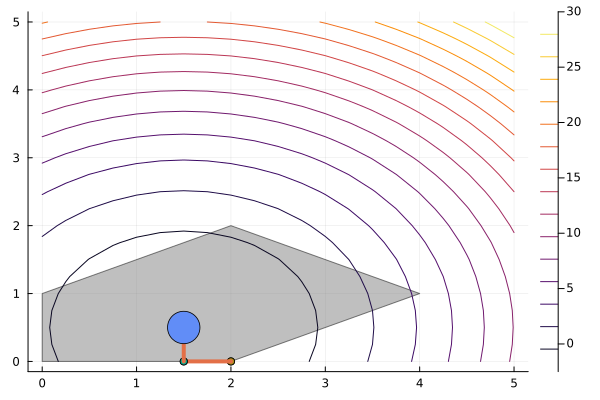

In [10]:
# Perturb the solution so that we fall into the middle
c = [-3.0; -1.0]

# Animate!

PlotRegion.plotregion([A -Matrix(1.0I,size(A,1),size(A,1))],b)
ezcontour!(0:0.25:5.0,0:0.25:5.0,x -> 0.5*dot(G*x,x) + dot(c,x))

x0 = [2.0;0.0]
W = [3,5]
S = qp_init(G,c,zeros(0,n),zeros(0),A,b,W,x0)
for i=1:10
    xold = S.x
    scatter!([S.x[1]], [S.x[2]], label="")
    qp_activeset_step!(S)
    xnew = S.x
    plot!([xold[1],xnew[1]], [xold[2],xnew[2]], label="", color=2, linewidth=4)
    if S.flag == true
        break
    end
end

if S.flag == true
    scatter!([S.x[1]], [S.x[2]], label="", markersize=18)
end
plot!()






Step: f= 0.2  x=[ 0.7, 0.2]  mu=[0.0 ,0.0 ,0.0 ]   note=stepped
xnew = [0.7058823529411764, 0.1764705882352941, 0.11764705882352938]
Step: f= 0.2  x=[ 0.7, 0.2]  mu=[0.0 ,0.0 ,0.0 ]   note=stepped
xnew = [0.7058823529411764, 0.1764705882352941, 0.11764705882352938]


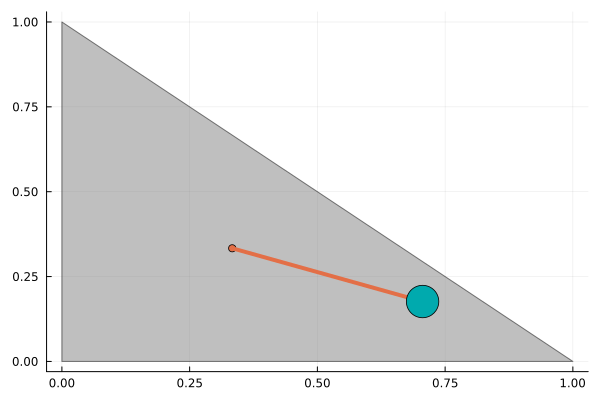

In [12]:
# Show the problem with a diagonal Hessian
G = zeros(3,3)
G[1,1] = 0.5
G[2,2] = 2 
G[3,3] = 3
c = zeros(3)
A = ones(1,3) # sum(x) = 1 
b = [1] 
B = Matrix(1.0I, 3, 3)
d = zeros(3) 

x0 = ones(3)/3
W0 = Int[] 

PlotRegion.plotregion(
    [A zeros(size(A,1),size(A,2)); 
     B -Matrix(1.0I,size(A,2),size(A,2))],[b; d])
#ezcontour!(0:0.25:5.0,0:0.25:5.0,x -> (0.5*dot(G*x,x) + dot(c,x)))

S = qp_init(G,c,A,b,B,d,W0,x0)
for i=1:10
    xold = S.x
    scatter!([S.x[1]], [S.x[2]], label="")
    qp_activeset_step!(S)
    xnew = S.x
    plot!([xold[1],xnew[1]], [xold[2],xnew[2]], label="", color=2, linewidth=4)
    @show xnew
    if S.flag == true
        break
    end
   
end

if S.flag == true
    scatter!([S.x[1]], [S.x[2]], label="", markersize=18)
end
plot!()


Step: f=-0.5  x=[ 0.5, 0.5]  mu=[0.0 ,0.0 ,0.0 ]   note=added 3
xnew = [0.5137014016435194, 0.4862985983564806, -5.551115123125783e-17]
Step: f=-0.6  x=[ 0.5, 0.5]  mu=[0.0 ,0.0 ,0.1 ]   note=stepped
xnew = [0.4509493104803126, 0.5490506895196875, -5.551115123125783e-17]
Step: f=-0.6  x=[ 0.5, 0.5]  mu=[0.0 ,0.0 ,0.1 ]   note=stepped
xnew = [0.4509493104803126, 0.5490506895196875, -5.551115123125783e-17]


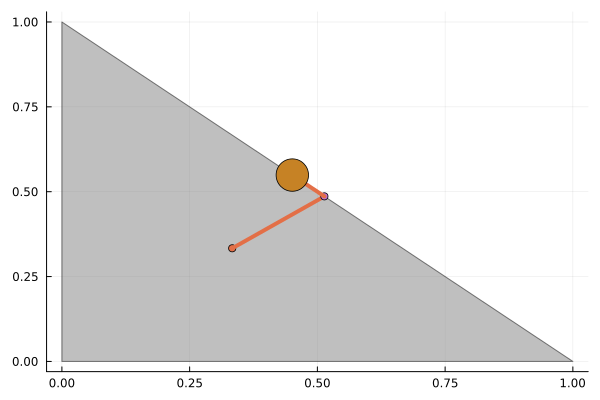

In [14]:
# Show the problem with a diagonal Hessian
G = rand(3,3) |> G -> -(G + G')
c = zeros(3)
A = ones(1,3) # sum(x) = 1 
b = [1] 
B = Matrix(1.0I, 3, 3)
d = zeros(3) 

x0 = ones(3)/3
W0 = Int[] 

PlotRegion.plotregion(
    [A zeros(size(A,1),size(A,2)); 
     B -Matrix(1.0I,size(A,2),size(A,2))],[b; d])
#ezcontour!(0:0.25:5.0,0:0.25:5.0,x -> (0.5*dot(G*x,x) + dot(c,x)))

S = qp_init(G,c,A,b,B,d,W0,x0)
for i=1:10
    xold = S.x
    scatter!([S.x[1]], [S.x[2]], label="")
    qp_activeset_step!(S)
    xnew = S.x
    plot!([xold[1],xnew[1]], [xold[2],xnew[2]], label="", color=2, linewidth=4)
    @show xnew
    if S.flag == true
        break
    end
   
end

if S.flag == true
    scatter!([S.x[1]], [S.x[2]], label="", markersize=18)
end
plot!()
